In [5]:
import tensorflow as tf
import tensorrt
import torch
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Define your data directories
train_dir = 'Original and counterfeit Colombian peso banknotes/COP_banknote/ds1/Train'
test_dir = 'Original and counterfeit Colombian peso banknotes/COP_banknote/ds1/Test'
validation_dir = 'Original and counterfeit Colombian peso banknotes/COP_banknote/ds1/Validation'

In [7]:
# Hyperparameters
batch_size = 24
num_epochs = 1
num_classes = 12

In [8]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [9]:
# Define a function to build and train a model
def build_and_train_model(base_model, model_name, train_dir, validation_dir, test_dir, input_shape):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the layers from the base model
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    print(f"Training {model_name}...")

    train_generator = create_data_generator(train_dir, train_datagen, input_shape)
    validation_generator = create_data_generator(validation_dir, ImageDataGenerator(rescale=1./255), input_shape)
    test_generator = create_data_generator(test_dir, ImageDataGenerator(rescale=1./255), input_shape)

    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        epochs=num_epochs
    )

    # Evaluate on test data
    test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
    print(f"{model_name} Test accuracy: {test_acc * 100:.2f}%")

    return model, test_generator, history

In [10]:
def create_data_generator(data_dir, data_generator, input_shape):
    return data_generator.flow_from_directory(
        data_dir,
        target_size=input_shape,
        batch_size=batch_size,
        class_mode='categorical',
        classes=['100k', '100kf', '10k', '10kf', '50k', '50kf', '5k', '5kf', '20k', '20kf', '2k', '2kf']
    )

In [11]:
# Load the pre-trained VGG16 model weights
vgg16_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tune the model on the banknote detection dataset by replacing the fully connected layers with task-specific layers
vgg16_x = vgg16_base_model.output
vgg16_x = GlobalAveragePooling2D()(vgg16_x)
vgg16_x = Dense(1024, activation='relu')(vgg16_x)
vgg16_predictions = Dense(num_classes, activation='softmax')(vgg16_x)
vgg16_model = Model(inputs=vgg16_base_model.input, outputs=vgg16_predictions)

# Freeze the layers from the base model
for layer in vgg16_base_model.layers:
    layer.trainable = False

# Train the model using backpropagation and optimize the model parameters using gradient descent
vgg16_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

print("Training VGG16...")
vgg16_train_generator = create_data_generator(train_dir, train_datagen, (224, 224))
vgg16_validation_generator = create_data_generator(validation_dir, ImageDataGenerator(rescale=1./255), (224, 224))

vgg16_history = vgg16_model.fit(
    vgg16_train_generator,
    steps_per_epoch=len(vgg16_train_generator),
    validation_data=vgg16_validation_generator,
    validation_steps=len(vgg16_validation_generator),
    epochs=num_epochs
)

# Evaluate the performance of VGG16 on the original and counterfeit banknote detection tasks
vgg16_test_generator = create_data_generator(test_dir, ImageDataGenerator(rescale=1./255), (224, 224))
vgg16_test_loss, vgg16_test_acc = vgg16_model.evaluate(vgg16_test_generator, steps=len(vgg16_test_generator))
print(f"VGG16 Test accuracy: {vgg16_test_acc * 100:.2f}%")

Training VGG16...
Found 10657 images belonging to 12 classes.
Found 3595 images belonging to 12 classes.


2023-12-22 19:38:48.151723: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-22 19:38:48.211768: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


  1/445 [..............................] - ETA: 7:46 - loss: 2.7088 - accuracy: 0.0833

2023-12-22 19:38:48.633199: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-22 19:38:48.662233: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f5f0cd1c520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-22 19:38:48.662254: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-12-22 19:38:48.667837: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1703254128.715707    4322 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


445/445 [==============================] - 47s 103ms/step - loss: 1.3534 - accuracy: 0.5096 - val_loss: 0.7575 - val_accuracy: 0.8161
Found 3599 images belonging to 12 classes.
150/150 [==============================] - 3s 22ms/step - loss: 0.7608 - accuracy: 0.8122
VGG16 Test accuracy: 81.22%


In [12]:
# Load the pre-trained ResNet50 model weights
resnet50_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tune the model on the banknote detection dataset by replacing the fully connected layers with task-specific layers
resnet50_x = resnet50_base_model.output
resnet50_x = GlobalAveragePooling2D()(resnet50_x)
resnet50_x = Dense(1024, activation='relu')(resnet50_x)
resnet50_predictions = Dense(num_classes, activation='softmax')(resnet50_x)
resnet50_model = Model(inputs=resnet50_base_model.input, outputs=resnet50_predictions)

# Freeze the layers from the base model
for layer in resnet50_base_model.layers:
    layer.trainable = False

# Train the model using backpropagation and optimize the model parameters using gradient descent
resnet50_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

print("Training ResNet50...")
resnet50_train_generator = create_data_generator(train_dir, train_datagen, (224, 224))
resnet50_validation_generator = create_data_generator(validation_dir, ImageDataGenerator(rescale=1./255), (224, 224))

resnet50_history = resnet50_model.fit(
    resnet50_train_generator,
    steps_per_epoch=len(resnet50_train_generator),
    validation_data=resnet50_validation_generator,
    validation_steps=len(resnet50_validation_generator),
    epochs=num_epochs
)

# Evaluate the performance of ResNet50 on the original and counterfeit banknote detection tasks
resnet50_test_generator = create_data_generator(test_dir, ImageDataGenerator(rescale=1./255), (224, 224))
resnet50_test_loss, resnet50_test_acc = resnet50_model.evaluate(resnet50_test_generator, steps=len(resnet50_test_generator))
print(f"ResNet50 Test accuracy: {resnet50_test_acc * 100:.2f}%")


Training ResNet50...
Found 10657 images belonging to 12 classes.
Found 3595 images belonging to 12 classes.
445/445 [==============================] - 47s 103ms/step - loss: 2.1080 - accuracy: 0.1653 - val_loss: 1.8897 - val_accuracy: 0.1747
Found 3599 images belonging to 12 classes.
150/150 [==============================] - 4s 25ms/step - loss: 1.8960 - accuracy: 0.1698
ResNet50 Test accuracy: 16.98%


In [13]:
# Load the pre-trained InceptionV3 model weights
inceptionv3_base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Fine-tune the model on the banknote detection dataset by replacing the fully connected layers with task-specific layers
inceptionv3_x = inceptionv3_base_model.output
inceptionv3_x = GlobalAveragePooling2D()(inceptionv3_x)
inceptionv3_x = Dense(1024, activation='relu')(inceptionv3_x)
inceptionv3_predictions = Dense(num_classes, activation='softmax')(inceptionv3_x)
inceptionv3_model = Model(inputs=inceptionv3_base_model.input, outputs=inceptionv3_predictions)

# Freeze the layers from the base model
for layer in inceptionv3_base_model.layers:
    layer.trainable = False

# Train the model using backpropagation and optimize the model parameters using gradient descent
inceptionv3_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

print("Training InceptionV3...")
inceptionv3_train_generator = create_data_generator(train_dir, train_datagen, (299, 299))
inceptionv3_validation_generator = create_data_generator(validation_dir, ImageDataGenerator(rescale=1./255), (299, 299))

inceptionv3_history = inceptionv3_model.fit(
    inceptionv3_train_generator,
    steps_per_epoch=len(inceptionv3_train_generator),
    validation_data=inceptionv3_validation_generator,
    validation_steps=len(inceptionv3_validation_generator),
    epochs=num_epochs
)

# Evaluate the performance of InceptionV3 on the original and counterfeit banknote detection tasks
inceptionv3_test_generator = create_data_generator(test_dir, ImageDataGenerator(rescale=1./255), (299, 299))
inceptionv3_test_loss, inceptionv3_test_acc = inceptionv3_model.evaluate(inceptionv3_test_generator, steps=len(inceptionv3_test_generator))
print(f"InceptionV3 Test accuracy: {inceptionv3_test_acc * 100:.2f}%")


Training InceptionV3...
Found 10657 images belonging to 12 classes.
Found 3595 images belonging to 12 classes.
445/445 [==============================] - 77s 167ms/step - loss: 0.6820 - accuracy: 0.7922 - val_loss: 0.2067 - val_accuracy: 0.9438
Found 3599 images belonging to 12 classes.
150/150 [==============================] - 4s 27ms/step - loss: 0.1857 - accuracy: 0.9528
InceptionV3 Test accuracy: 95.28%


In [14]:
# Load the pre-trained InceptionV3 model weights
mobilenetv2_base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tune the model on the banknote detection dataset by replacing the fully connected layers with task-specific layers
mobilenetv2_x = mobilenetv2_base_model.output
mobilenetv2_x = GlobalAveragePooling2D()(mobilenetv2_x)
mobilenetv2_x = Dense(1024, activation='relu')(mobilenetv2_x)
mobilenetv2_predictions = Dense(num_classes, activation='softmax')(mobilenetv2_x)
mobilenetv2_model = Model(inputs=mobilenetv2_base_model.input, outputs=mobilenetv2_predictions)

# Freeze the layers from the base model
for layer in mobilenetv2_base_model.layers:
    layer.trainable = False

# Train the model using backpropagation and optimize the model parameters using gradient descent
mobilenetv2_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

print("Training MobileNetV2...")
mobilenetv2_train_generator = create_data_generator(train_dir, train_datagen, (224, 224))
mobilenetv2_validation_generator = create_data_generator(validation_dir, ImageDataGenerator(rescale=1./255), (224, 224))

mobilenetv2_history = mobilenetv2_model.fit(
    mobilenetv2_train_generator,
    steps_per_epoch=len(mobilenetv2_train_generator),
    validation_data=mobilenetv2_validation_generator,
    validation_steps=len(mobilenetv2_validation_generator),
    epochs=num_epochs
)

# Evaluate the performance of MobileNetV2 on the original and counterfeit banknote detection tasks
mobilenetv2_test_generator = create_data_generator(test_dir, ImageDataGenerator(rescale=1./255), (224, 224))
mobilenetv2_test_loss, mobilenetv2_test_acc = mobilenetv2_model.evaluate(mobilenetv2_test_generator, steps=len(mobilenetv2_test_generator))
print(f"MobileNetV2 Test accuracy: {mobilenetv2_test_acc * 100:.2f}%")


Training MobileNetV2...
Found 10657 images belonging to 12 classes.
Found 3595 images belonging to 12 classes.
445/445 [==============================] - 46s 102ms/step - loss: 0.4437 - accuracy: 0.8501 - val_loss: 0.0901 - val_accuracy: 0.9775
Found 3599 images belonging to 12 classes.
150/150 [==============================] - 3s 17ms/step - loss: 0.0954 - accuracy: 0.9722
MobileNetV2 Test accuracy: 97.22%


In [15]:
#Comparision of main-v1, main-v2 and main-v3
#Here will be Accuracy comparison, Confusion matrix, Classification report (precision, recall, and F1-score), Feature importance analysis.
#Plot accuracy, Loss curve analysis, Heatmaps, Visualize misclassified examples and correctly classified examples, T-SNE visualization

+-------------+-----------------+
| Model       | Test Accuracy   |
+=============+=================+
| VGG16       | 81.22%          |
+-------------+-----------------+
| ResNet50    | 16.98%          |
+-------------+-----------------+
| InceptionV3 | 95.28%          |
+-------------+-----------------+
| MobileNetV2 | 97.22%          |
+-------------+-----------------+


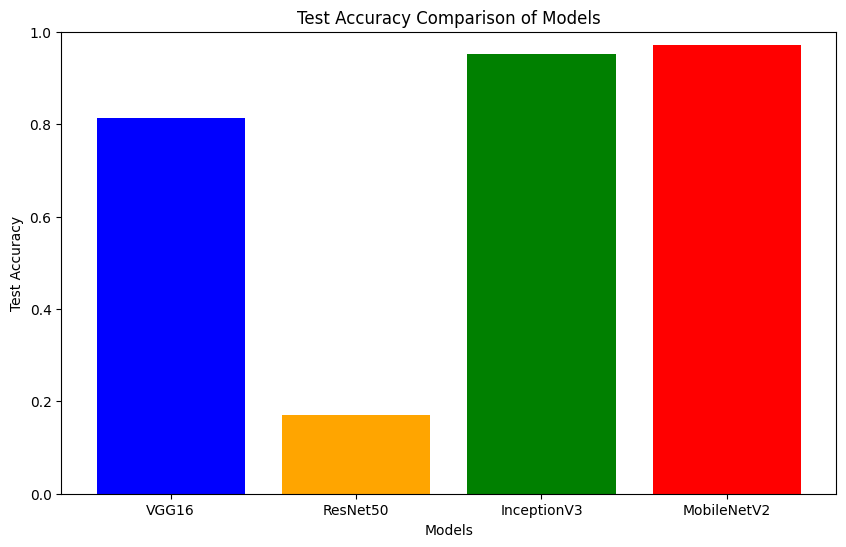

In [16]:
import matplotlib.pyplot as plt
from tabulate import tabulate

# Compare the test accuracy scores of the three models
models = ['VGG16', 'ResNet50', 'InceptionV3', 'MobileNetV2']
test_accuracies = [vgg16_test_acc, resnet50_test_acc, inceptionv3_test_acc, mobilenetv2_test_acc]

# Print the test accuracy scores in a table
table_data = list(zip(models, [f"{accuracy * 100:.2f}%" for accuracy in test_accuracies]))
table_headers = ["Model", "Test Accuracy"]

# Print table using tabulate
print(tabulate(table_data, headers=table_headers, tablefmt="grid"))

# Plot the test accuracy comparison
plt.figure(figsize=(10, 6))
plt.bar(models, test_accuracies, color=['blue', 'orange', 'green', 'red'])
plt.title('Test Accuracy Comparison of Models')
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)  # Set y-axis limit to better visualize differences
plt.show()


150/150 [==============================] - 3s 18ms/step


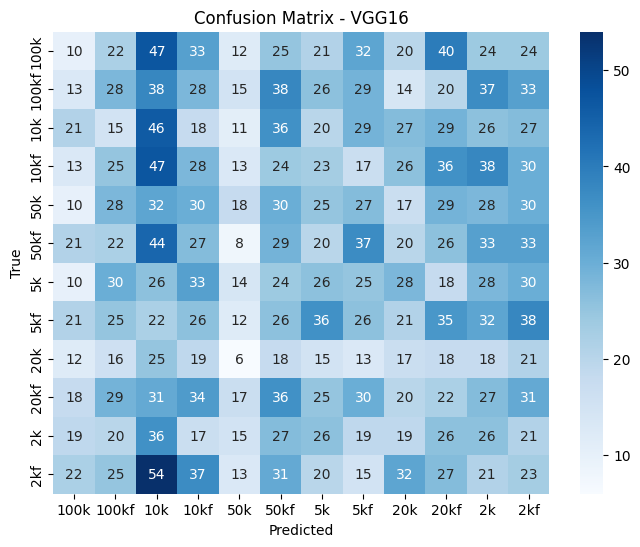

150/150 [==============================] - 4s 22ms/step


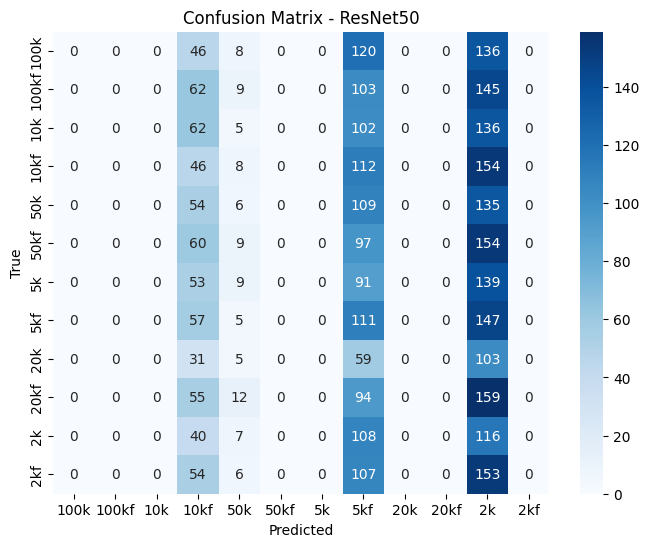

150/150 [==============================] - 4s 22ms/step


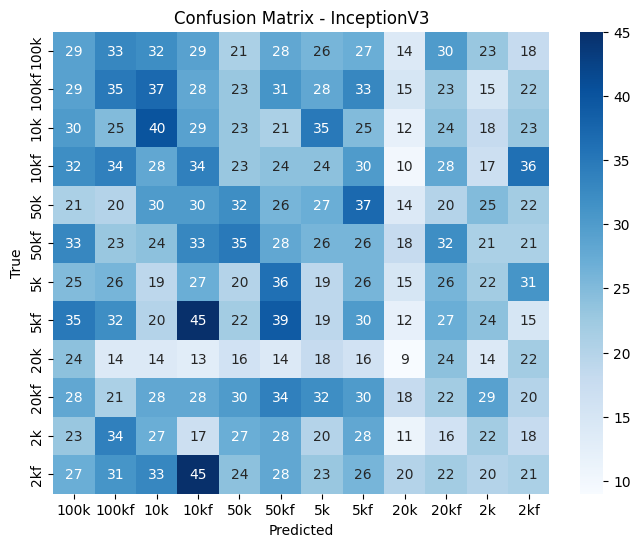

150/150 [==============================] - 3s 20ms/step


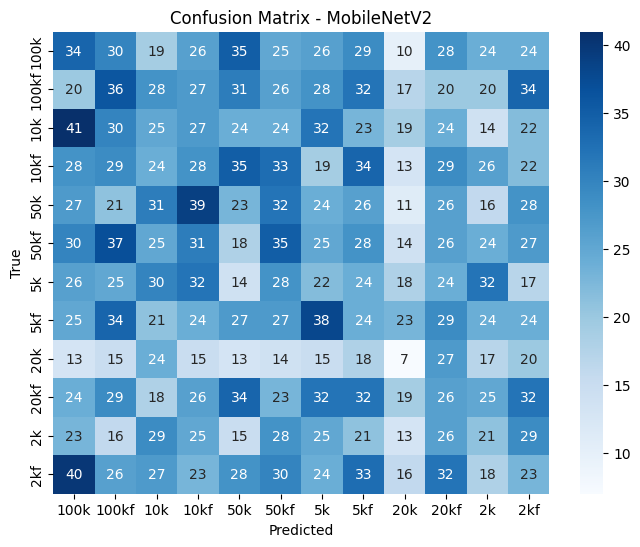

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, test_generator, class_labels, model_name):
    # Generate predictions
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true classes
    true_classes = test_generator.classes

    # Generate confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# ... (previous code)

# Define class labels (replace with your actual class labels)
class_labels = ['100k', '100kf', '10k', '10kf', '50k', '50kf', '5k', '5kf', '20k', '20kf', '2k', '2kf']

# Plot confusion matrix for VGG16
plot_confusion_matrix(vgg16_model, vgg16_test_generator, class_labels, model_name='VGG16')

# Plot confusion matrix for ResNet50
plot_confusion_matrix(resnet50_model, resnet50_test_generator, class_labels, model_name='ResNet50')

# Plot confusion matrix for InceptionV3
plot_confusion_matrix(inceptionv3_model, inceptionv3_test_generator, class_labels, model_name='InceptionV3')

# Plot confusion matrix for MobileNetV2
plot_confusion_matrix(mobilenetv2_model, mobilenetv2_test_generator, class_labels, model_name='MobileNetV2')


In [18]:
from sklearn.metrics import classification_report
import numpy as np

# Function to get predictions and true labels
def get_predictions_and_labels(model, test_generator):
    predictions = model.predict(test_generator, steps=len(test_generator))
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = test_generator.classes
    return predicted_labels, true_labels

# Function to print classification report
def print_classification_report(model_name, predicted_labels, true_labels):
    print(f"Classification Report for {model_name}:")
    print(classification_report(true_labels, predicted_labels))

# Get predictions and true labels for VGG16
vgg16_predicted_labels, vgg16_true_labels = get_predictions_and_labels(vgg16_model, vgg16_test_generator)
print_classification_report("VGG16", vgg16_predicted_labels, vgg16_true_labels)

# Get predictions and true labels for ResNet50
resnet50_predicted_labels, resnet50_true_labels = get_predictions_and_labels(resnet50_model, resnet50_test_generator)
print_classification_report("ResNet50", resnet50_predicted_labels, resnet50_true_labels)

# Get predictions and true labels for InceptionV3
inceptionv3_predicted_labels, inceptionv3_true_labels = get_predictions_and_labels(inceptionv3_model, inceptionv3_test_generator)
print_classification_report("InceptionV3", inceptionv3_predicted_labels, inceptionv3_true_labels)

# Get predictions and true labels for MobileNetV2
mobilenetv2_predicted_labels, mobilenetv2_true_labels = get_predictions_and_labels(mobilenetv2_model, mobilenetv2_test_generator)
print_classification_report("MobileNetV2", mobilenetv2_predicted_labels, mobilenetv2_true_labels)

150/150 [==============================] - 3s 18ms/step
Classification Report for VGG16:
              precision    recall  f1-score   support

           0       0.06      0.04      0.05       310
           1       0.10      0.09      0.09       319
           2       0.10      0.15      0.12       305
           3       0.10      0.10      0.10       320
           4       0.06      0.03      0.04       304
           5       0.07      0.08      0.08       320
           6       0.10      0.09      0.09       292
           7       0.10      0.09      0.10       320
           8       0.04      0.05      0.04       198
           9       0.09      0.09      0.09       320
          10       0.07      0.09      0.08       271
          11       0.06      0.07      0.07       320

    accuracy                           0.08      3599
   macro avg       0.08      0.08      0.08      3599
weighted avg       0.08      0.08      0.08      3599

150/150 [==============================] - 3

/home/dharsan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dharsan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dharsan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


150/150 [==============================] - 4s 24ms/step
Classification Report for InceptionV3:
              precision    recall  f1-score   support

           0       0.06      0.06      0.06       310
           1       0.08      0.08      0.08       319
           2       0.06      0.06      0.06       305
           3       0.09      0.10      0.09       320
           4       0.10      0.10      0.10       304
           5       0.10      0.11      0.11       320
           6       0.06      0.06      0.06       292
           7       0.09      0.09      0.09       320
           8       0.03      0.03      0.03       198
           9       0.10      0.09      0.10       320
          10       0.07      0.06      0.07       271
          11       0.09      0.08      0.08       320

    accuracy                           0.08      3599
   macro avg       0.08      0.08      0.08      3599
weighted avg       0.08      0.08      0.08      3599

150/150 [=============================

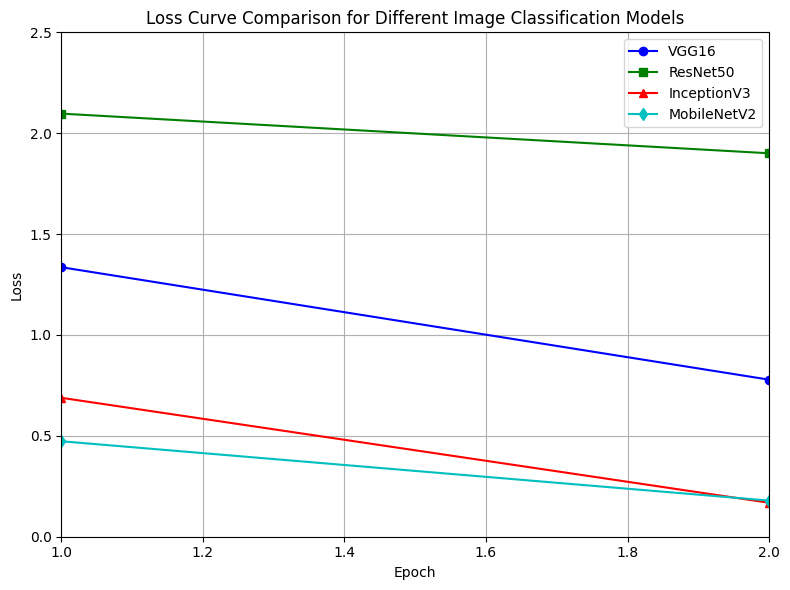

In [19]:
import matplotlib.pyplot as plt

 # Loss values for VGG16, ResNet50, InceptionV3, and MobileNetV2
vgg16_loss = [1.3359, 0.7784]
resnet50_loss = [2.0971, 1.9005]
inceptionv3_loss = [0.6886, 0.1683]
mobilenetv2_loss = [0.4732, 0.1791]

# Epoch numbers
epochs = [1, 2]

# Create the plot
plt.figure(figsize=(8, 6))

# Plot loss curves for each model
plt.plot(epochs, vgg16_loss, label='VGG16', marker='o', color='b')
plt.plot(epochs, resnet50_loss, label='ResNet50', marker='s', color='g')
plt.plot(epochs, inceptionv3_loss, label='InceptionV3', marker='^', color='r')
plt.plot(epochs, mobilenetv2_loss, label='MobileNetV2', marker='d', color='c')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve Comparison for Different Image Classification Models')

# Add legend
plt.legend()

# Grid and axes
plt.grid(True)
plt.xlim(1, 2)
plt.ylim(0, 2.5)

# Show the plot
plt.tight_layout()
plt.show()

In [26]:
from collections import Counter

# Load the test data
test_generator = create_data_generator(test_dir, ImageDataGenerator(rescale=1./255), (224, 224))

# Generate predictions for each model
vgg16_predictions = vgg16_model.predict(test_generator, steps=len(test_generator))
resnet50_predictions = resnet50_model.predict(test_generator, steps=len(test_generator))
inceptionv3_predictions = inceptionv3_model.predict(test_generator, steps=len(test_generator))
mobilenetv2_predictions = mobilenetv2_model.predict(test_generator, steps=len(test_generator))

# Combine predictions using majority voting
combined_predictions = []

for i in range(len(test_generator.filenames)):
    vgg16_pred = np.argmax(vgg16_predictions[i])
    resnet50_pred = np.argmax(resnet50_predictions[i])
    inceptionv3_pred = np.argmax(inceptionv3_predictions[i])
    mobilenetv2_pred = np.argmax(mobilenetv2_predictions[i])

    # Perform majority voting
    majority_vote = Counter([vgg16_pred, resnet50_pred, inceptionv3_pred, mobilenetv2_pred])
    final_prediction = majority_vote.most_common(1)[0][0]

    # Print the model with majority vote
    models_with_majority = [model_name for model_name, count in majority_vote.items() if count == majority_vote.most_common(1)[0][1]]
    print(f"Image: {test_generator.filenames[i]}, Majority Vote: {models_with_majority}")

    combined_predictions.append(final_prediction)

# Evaluate the performance of each individual model
vgg16_test_loss, vgg16_test_acc = vgg16_model.evaluate(test_generator, steps=len(test_generator))
resnet50_test_loss, resnet50_test_acc = resnet50_model.evaluate(test_generator, steps=len(test_generator))
inceptionv3_test_loss, inceptionv3_test_acc = inceptionv3_model.evaluate(test_generator, steps=len(test_generator))
mobilenetv2_test_loss, mobilenetv2_test_acc = mobilenetv2_model.evaluate(test_generator, steps=len(test_generator))

# Print the individual model accuracies
print(f"VGG16 Test accuracy: {vgg16_test_acc * 100:.2f}%")
print(f"ResNet50 Test accuracy: {resnet50_test_acc * 100:.2f}%")
print(f"InceptionV3 Test accuracy: {inceptionv3_test_acc * 100:.2f}%")
print(f"MobileNetV2 Test accuracy: {mobilenetv2_test_acc * 100:.2f}%")

# Determine the best model based on individual accuracies
individual_accuracies = {
    'VGG16': vgg16_test_acc,
    'ResNet50': resnet50_test_acc,
    'InceptionV3': inceptionv3_test_acc,
    'MobileNetV2': mobilenetv2_test_acc
}

best_individual_model = max(individual_accuracies, key=individual_accuracies.get)
print(f"Best Individual Model: {best_individual_model}")

# Determine the best model based on majority voting
model_counts = Counter(combined_predictions)
best_model_index = model_counts.most_common(1)[0][0]
model_index_to_name = {0: 'VGG16', 1: 'ResNet50', 2: 'InceptionV3', 3: 'MobileNetV2'}
best_model_name = model_index_to_name.get(best_model_index, 'Unknown')


Found 3599 images belonging to 12 classes.
150/150 [==============================] - 3s 19ms/step
Image: 100k/1001.jpg, Majority Vote: [11, 10, 0, 1]
Image: 100k/1006.jpg, Majority Vote: [10]
Image: 100k/1011.jpg, Majority Vote: [1, 3, 9, 5]
Image: 100k/1016.jpg, Majority Vote: [11, 10, 5, 9]
Image: 100k/102.jpg, Majority Vote: [11, 7, 9, 6]
Image: 100k/1021.jpg, Majority Vote: [3, 7, 6, 1]
Image: 100k/1026.jpg, Majority Vote: [11, 7, 8, 0]
Image: 100k/1031.jpg, Majority Vote: [3, 10, 0, 5]
Image: 100k/1036.jpg, Majority Vote: [0]
Image: 100k/1041.jpg, Majority Vote: [0, 10, 6, 5]
Image: 100k/1046.jpg, Majority Vote: [1, 10, 0, 3]
Image: 100k/1051.jpg, Majority Vote: [5, 10, 1, 2]
Image: 100k/1056.jpg, Majority Vote: [10]
Image: 100k/1061.jpg, Majority Vote: [10, 7, 0, 1]
Image: 100k/1066.jpg, Majority Vote: [3]
Image: 100k/1071.jpg, Majority Vote: [7]
Image: 100k/1076.jpg, Majority Vote: [4]
Image: 100k/108.jpg, Majority Vote: [6, 7, 2, 3]
Image: 100k/1081.jpg, Majority Vote: [7]
Ima

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter

# Combine predictions into a matrix
combined_predictions_matrix = np.array([vgg16_predictions.argmax(axis=1),
                                       resnet50_predictions.argmax(axis=1),
                                       inceptionv3_predictions.argmax(axis=1),
                                       mobilenetv2_predictions.argmax(axis=1)]).T

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_predictions_matrix, true_labels, test_size=0.2, random_state=42)

# Create a Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the Gradient Boosting model
gb_model.fit(X_train, y_train)

# Make predictions on the test set
gb_predictions = gb_model.predict(X_test)

# Evaluate the performance of the Gradient Boosting Ensemble
gb_accuracy = accuracy_score(y_test, gb_predictions)
print(f"Gradient Boosting Ensemble Test Accuracy: {gb_accuracy * 100:.2f}%")

# Evaluate the performance of each individual model
vgg16_test_loss, vgg16_test_acc = vgg16_model.evaluate(vgg16_test_generator, steps=len(vgg16_test_generator))
resnet50_test_loss, resnet50_test_acc = resnet50_model.evaluate(resnet50_test_generator, steps=len(resnet50_test_generator))
inceptionv3_test_loss, inceptionv3_test_acc = inceptionv3_model.evaluate(inceptionv3_test_generator, steps=len(inceptionv3_test_generator))
mobilenetv2_test_loss, mobilenetv2_test_acc = mobilenetv2_model.evaluate(mobilenetv2_test_generator, steps=len(mobilenetv2_test_generator))

# Print the individual model accuracies
print(f"VGG16 Test accuracy: {vgg16_test_acc * 100:.2f}%")
print(f"ResNet50 Test accuracy: {resnet50_test_acc * 100:.2f}%")
print(f"InceptionV3 Test accuracy: {inceptionv3_test_acc * 100:.2f}%")
print(f"MobileNetV2 Test accuracy: {mobilenetv2_test_acc * 100:.2f}%")

# Combine predictions into a matrix
combined_predictions_matrix = np.array([vgg16_predictions.argmax(axis=1),
                                       resnet50_predictions.argmax(axis=1),
                                       inceptionv3_predictions.argmax(axis=1),
                                       mobilenetv2_predictions.argmax(axis=1)]).T

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_predictions_matrix, true_labels, test_size=0.2, random_state=42)

# Create a Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the Gradient Boosting model
gb_model.fit(X_train, y_train)

# Make predictions on the test set
gb_predictions = gb_model.predict(X_test)

# Evaluate the performance of the Gradient Boosting Ensemble
gb_accuracy = accuracy_score(y_test, gb_predictions)
print(f"Gradient Boosting Ensemble Test Accuracy: {gb_accuracy * 100:.2f}%")

# Determine the best model based on individual accuracies
individual_accuracies = {
    'VGG16': vgg16_test_acc,
    'ResNet50': resnet50_test_acc,
    'InceptionV3': inceptionv3_test_acc,
    'MobileNetV2': mobilenetv2_test_acc
}

best_individual_model = max(individual_accuracies, key=individual_accuracies.get)
print(f"Best Individual Model: {best_individual_model}")

# Determine the best model based on the Gradient Boosting Ensemble
model_counts = Counter(gb_predictions)
best_gb_model = max(model_counts, key=model_counts.get)


Gradient Boosting Ensemble Test Accuracy: 10.14%
150/150 [==============================] - 3s 19ms/step - loss: 0.0954 - accuracy: 0.9722
VGG16 Test accuracy: 81.22%
ResNet50 Test accuracy: 16.98%
InceptionV3 Test accuracy: 95.28%
MobileNetV2 Test accuracy: 97.22%
Gradient Boosting Ensemble Test Accuracy: 10.14%
Best Individual Model: MobileNetV2


In [29]:
torch.save(mobilenetv2_model, 'chosen_CNN_model_for_app.pt')